<a href="https://www.kaggle.com/cameron858/spaceship-titanic-various-models-fe-80?scriptVersionId=89297306" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Load training data into pandas dataframe

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

print(f'{train.head()}\n{train.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   


# Initial EDA # 

## Dealing with NaNs ##

In [203]:
# examine Nans
print(f'Training NaNs:\n{train.isnull().sum()}\n\nTesting NaNs:\n{test.isnull().sum()}')
print(f'\nThe data contains {train.isnull().sum().sum() + test.isnull().sum().sum()} NaNs')

Training NaNs:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Testing NaNs:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

The data contains 3441 NaNs


There are alot of NaNs in this dataset.

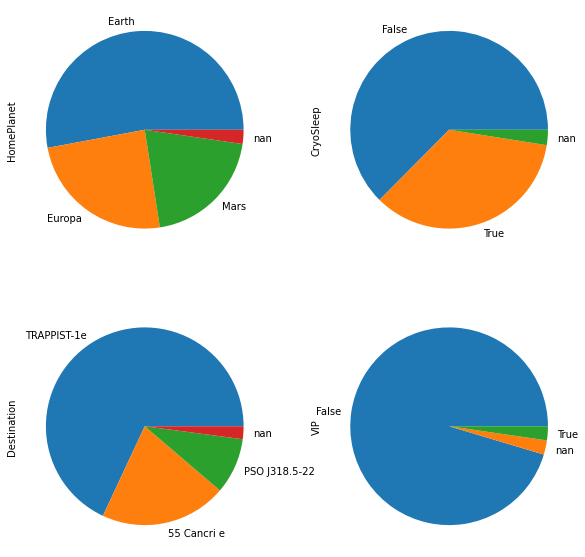

In [204]:
# class imbalance including NaNs

fig1, ax = plt.subplots(2, 2, figsize=(10, 10))
idx = 0

for row in [0, 1]:
    for col in [0, 1]:
        feat = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP'][idx]
        train[feat].value_counts(dropna=False).plot(kind='pie', ax = ax[row][col])
        idx += 1

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RoomService'}>,
        <AxesSubplot:title={'center':'FoodCourt'}>],
       [<AxesSubplot:title={'center':'ShoppingMall'}>,
        <AxesSubplot:title={'center':'Spa'}>,
        <AxesSubplot:title={'center':'VRDeck'}>]], dtype=object)

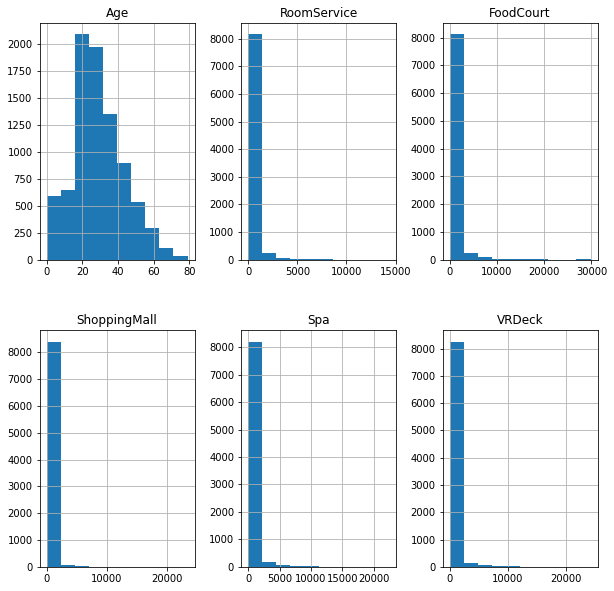

In [205]:
# distributions of numerical features
original_numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig2, ax = plt.subplots(2, 3, figsize=(10, 10))
train[original_numerical_features].hist(ax=ax)

The numerical features are very skewed (apart from Age)

We need to impute the missing values, the question is what method is best?
One way would be to impute with the most common value for each feature as such:
``` python
# extract columns with NaNs
contains_nans = train.columns[train.isnull().any()]

# fills with most common for all cols. Very basic.
for col in contains_nans:
    temp = train[col].value_counts().index[0]
    train[col] = train[col].fillna(temp)
    test[col] = test[col].fillna(temp)
```
However, we can attempt a slightly more foccused imputation for each feature.

In [206]:
# extract columns with NaNs
contains_nans = train.columns[train.isnull().any()]

# index removes transported to avod error when filling test data
for col in train.isnull().sum().index[0:-1]:
    # check if contains nans and is a float64
    if train[col].isnull().sum() > 0 and train[col].dtypes == 'float64':
        temp = train[col].median()
    else:
        # fill with most common value
        temp = train[col].value_counts().index[0]
        
    train[col] = train[col].fillna(temp)
    test[col] = test[col].fillna(temp)
    
print(f'Training NaNs:\n{train.isnull().sum()}\n\nTesting NaNs:\n{test.isnull().sum()}')
print(f'\nThe data contains {train.isnull().sum().sum() + test.isnull().sum().sum()} NaNs')

Training NaNs:
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

Testing NaNs:
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

The data contains 0 NaNs


Lets again plot the distributions for the features

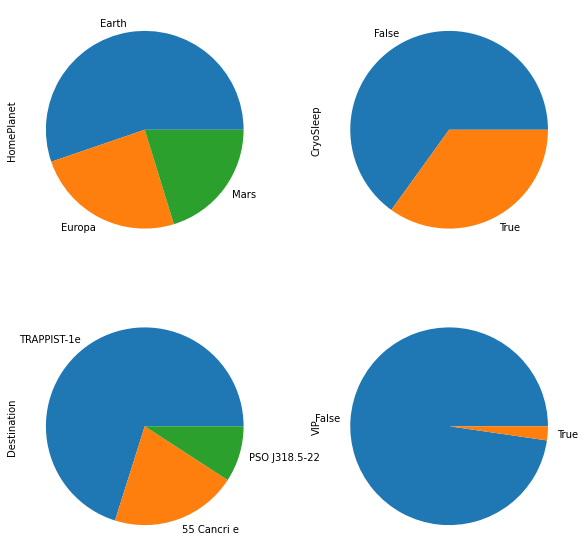

In [207]:
# class imbalance including NaNs

fig3, ax = plt.subplots(2, 2, figsize=(10, 10))
idx = 0

for row in [0, 1]:
    for col in [0, 1]:
        feat = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP'][idx]
        train[feat].value_counts(dropna=False).plot(kind='pie', ax = ax[row][col])
        idx += 1

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RoomService'}>,
        <AxesSubplot:title={'center':'FoodCourt'}>],
       [<AxesSubplot:title={'center':'ShoppingMall'}>,
        <AxesSubplot:title={'center':'Spa'}>,
        <AxesSubplot:title={'center':'VRDeck'}>]], dtype=object)

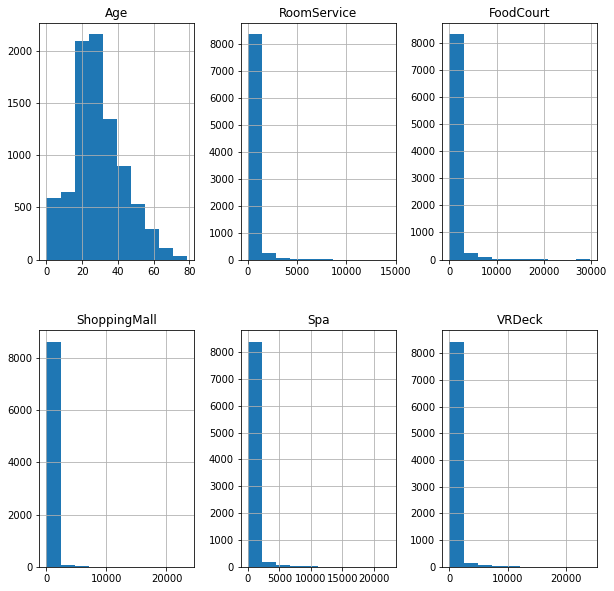

In [208]:
# distributions of numerical features
original_numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig4, ax = plt.subplots(2, 3, figsize=(10, 10))
train[original_numerical_features].hist(ax=ax)

<h1><center> Feature creation <center><h1>

Numerous features can be split into more features. The PassengerId has the format of 'XXXX_XX'. We can split the first 4 digits, and last 2 into seperate features. The cabin format is of "deck / number / side (port P or startboard S). We can seperate these into seperate columns. It is a valid assumption that families travel together, and stay in the same rooms. First and Last name features can be created from the original names feature. The 3 original features have been dropped afterwards.

In [209]:
# splitting PassengerId feature
train[['PassengerId_0', 'PassengerId_1']] = train['PassengerId'].str.split('_', 1, expand=True)
test[['PassengerId_0', 'PassengerId_1']] = test['PassengerId'].str.split('_', 1, expand=True)

# splitting Cabin feature
train[['Deck', 'Number', 'Side']] = train['Cabin'].str.split('/', 2, expand=True)
test[['Deck', 'Number', 'Side']] = test['Cabin'].str.split('/', 2, expand=True)

# splitting Name feature
train[['First name', 'Family name']] = train['Name'].str.split(' ', 1, expand=True)
test[['First name', 'Family name']] = test['Name'].str.split(' ', 1, expand=True)

# drop old features
train.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)
test.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)

# snacks 
train['Food/drink'] = train['RoomService'] + train['FoodCourt']
test['Food/drink'] = test['RoomService'] + test['FoodCourt']

# Entertainment
train['Entertainment'] = train['Spa'] + train['VRDeck']
test['Entertainment'] = test['Spa'] + test['VRDeck']

# Total spent
train['TotalSpent'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']
test['TotalSpent'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']

# baller: CryoSleep = False and TotalSpent > TotalSpent.median()

# log transform of age
train['LogAge'] = (train['Age'] - train['Age'].min() + 1).transform(np.log)
test['LogAge'] = (test['Age'] - test['Age'].min() + 1).transform(np.log)

In [210]:
# an attempt to make a 'Class' feature wil be done
# WIP

print(f'Training:\n{train.head()}\nTesting:\n{test.head()}')

Training:
  HomePlanet  CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
0     Europa      False  TRAPPIST-1e  39.0  False          0.0        0.0   
1      Earth      False  TRAPPIST-1e  24.0  False        109.0        9.0   
2     Europa      False  TRAPPIST-1e  58.0   True         43.0     3576.0   
3     Europa      False  TRAPPIST-1e  33.0  False          0.0     1283.0   
4      Earth      False  TRAPPIST-1e  16.0  False        303.0       70.0   

   ShoppingMall     Spa  VRDeck  ...  PassengerId_1 Deck Number Side  \
0           0.0     0.0     0.0  ...             01    B      0    P   
1          25.0   549.0    44.0  ...             01    F      0    S   
2           0.0  6715.0    49.0  ...             01    A      0    S   
3         371.0  3329.0   193.0  ...             02    A      0    S   
4         151.0   565.0     2.0  ...             01    F      1    S   

  First name  Family name Food/drink Entertainment  TotalSpent    LogAge  
0      Maham    Ofr

Scale continuous features, and impute missing values.

In [211]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# scale continuous features
continuous_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Food/drink', 'Entertainment', 'TotalSpent', 'LogAge']
min_max_scaler = MinMaxScaler()
train[continuous_cols] = min_max_scaler.fit_transform(train[continuous_cols])
test[continuous_cols] = min_max_scaler.fit_transform(test[continuous_cols])

In [212]:
from sklearn.preprocessing import LabelEncoder

def encode_df_cols(df, columns):
    for col in columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype('str'))   
    return df

cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Number', 'Side', 'First name', 'Family name', 'PassengerId_0', 'PassengerId_1']
train = encode_df_cols(train, cat_cols)
test = encode_df_cols(test, cat_cols)

print(f'Training:\n{train.head()}\nTesting:\n{test.head()}')

Training:
   HomePlanet  CryoSleep  Destination       Age  VIP  RoomService  FoodCourt  \
0           1          0            2  0.493671    0     0.000000   0.000000   
1           0          0            2  0.303797    0     0.007608   0.000302   
2           1          0            2  0.734177    1     0.003001   0.119948   
3           1          0            2  0.417722    0     0.000000   0.043035   
4           0          0            2  0.202532    0     0.021149   0.002348   

   ShoppingMall       Spa    VRDeck  ...  PassengerId_1  Deck  Number  Side  \
0      0.000000  0.000000  0.000000  ...              0     1       0     0   
1      0.001064  0.024500  0.001823  ...              0     5       0     1   
2      0.000000  0.299670  0.002030  ...              0     0       0     1   
3      0.015793  0.148563  0.007997  ...              1     0       0     1   
4      0.006428  0.025214  0.000083  ...              0     5       1     1   

   First name  Family name  Food/d

In [213]:
# double check no NaNs exist
train.isnull().sum()

HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Transported      0
PassengerId_0    0
PassengerId_1    0
Deck             0
Number           0
Side             0
First name       0
Family name      0
Food/drink       0
Entertainment    0
TotalSpent       0
LogAge           0
dtype: int64

# Feature Selections #

This sections aims to evaluate each feature in relation to the target ('Transported'). This should assist our models decisions. The numerical and categorical features will be evaluated seperately.

<h2> Numerical Features <h2>

In [214]:
# list numerical features from previous section
continuous_cols

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Food/drink',
 'Entertainment',
 'TotalSpent',
 'LogAge']

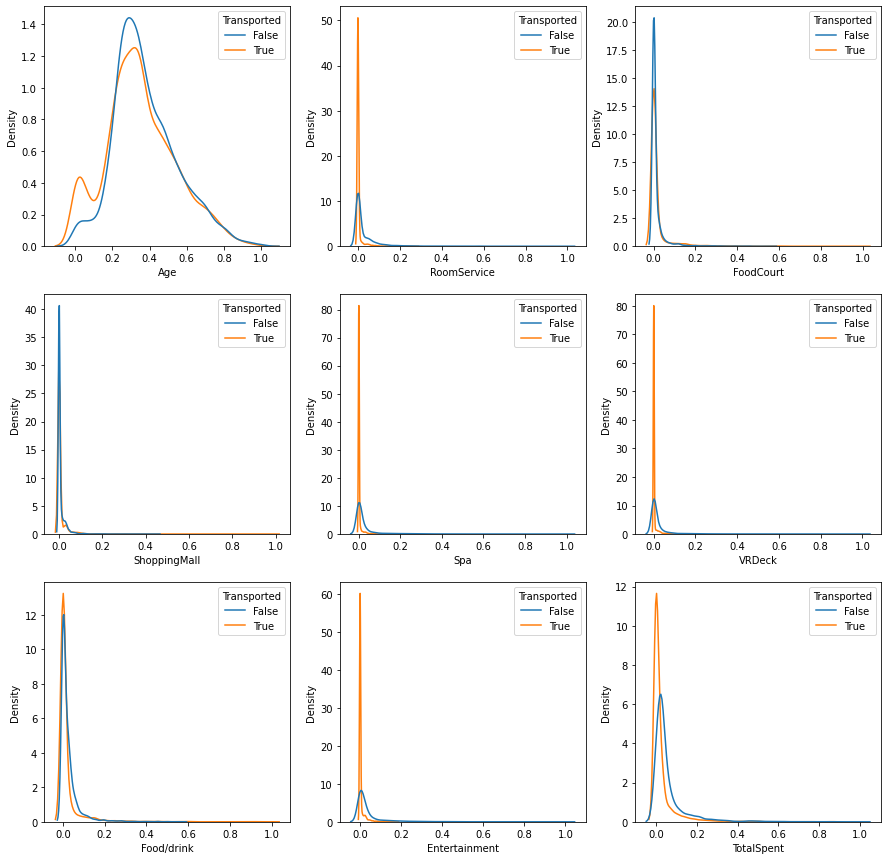

In [215]:
import seaborn as sns

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
idx = 0

for row in range(0,3):
    for col in range(0,3):
        sns.kdeplot(data=train, x=continuous_cols[idx], hue="Transported", ax=ax[row][col])
        idx+=1

<AxesSubplot:>

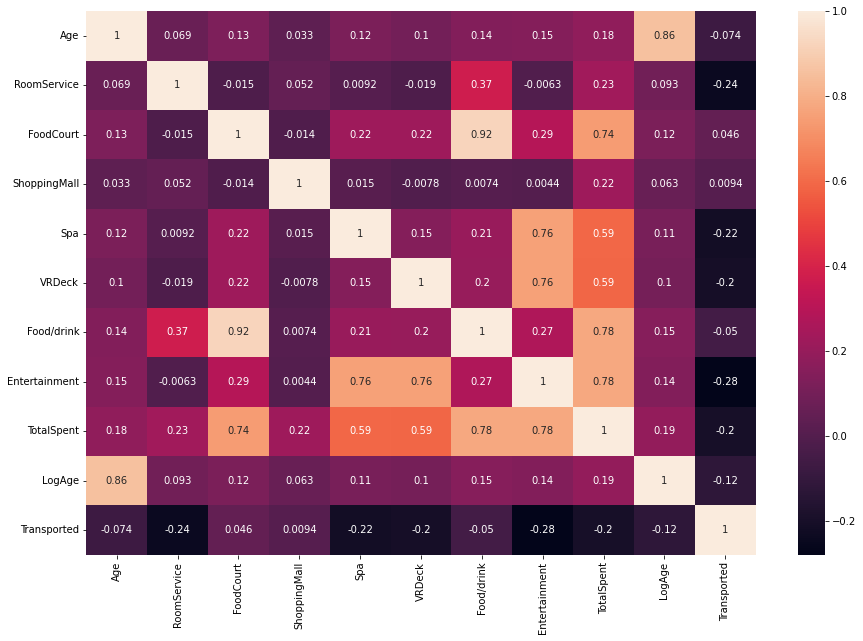

In [216]:
fig, ax = plt.subplots(figsize=(15, 10))

# astype(float) to avoid empty dataframe error
numerical_corrs = train[continuous_cols + ['Transported']].astype(float).corr()
sns.heatmap(numerical_corrs, annot=True, ax=ax)

In [217]:
# sort numerical features from largest to smallest abs correlation
print(numerical_corrs['Transported'].abs().sort_values(ascending=False))

Transported      1.000000
Entertainment    0.279443
RoomService      0.241124
Spa              0.218545
VRDeck           0.204874
TotalSpent       0.199514
LogAge           0.120084
Age              0.074233
Food/drink       0.050369
FoodCourt        0.045583
ShoppingMall     0.009391
Name: Transported, dtype: float64


## Categorical features ##

<AxesSubplot:>

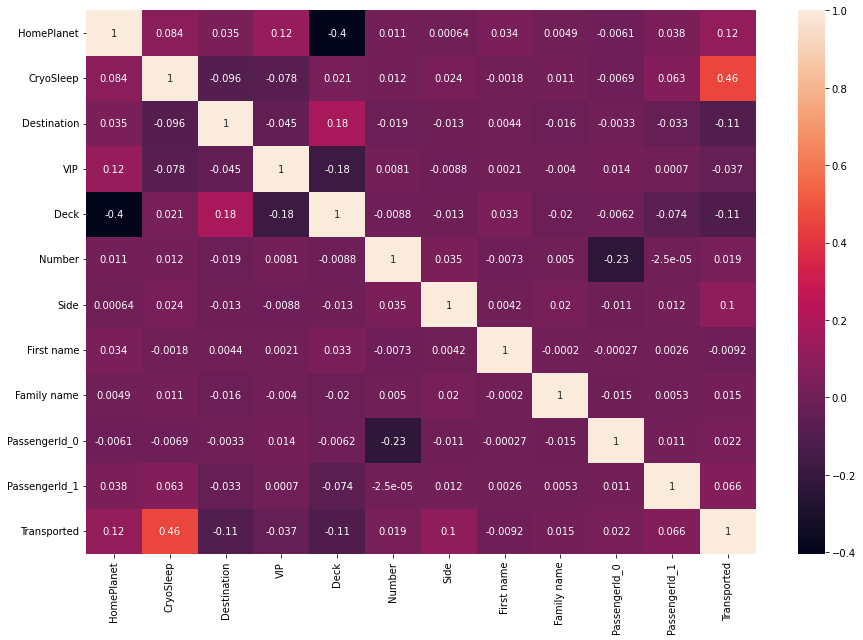

In [218]:
fig, ax = plt.subplots(figsize=(15, 10))
categorical_corrs = train[cat_cols + ['Transported']].corr()
sns.heatmap(categorical_corrs, annot=True)

In [219]:
# sort categorical features from largest to smallest abs correlation
print(categorical_corrs['Transported'].abs().sort_values(ascending=False))

Transported      1.000000
CryoSleep        0.460132
HomePlanet       0.115461
Deck             0.113992
Destination      0.108152
Side             0.101397
PassengerId_1    0.066390
VIP              0.037261
PassengerId_0    0.021825
Number           0.019393
Family name      0.014651
First name       0.009164
Name: Transported, dtype: float64


## Dropping redundant features ##
# Sometimes less is more #

It is clear from above that multiple features provide almost no tangible input to the models.

In [220]:
# see total features corrs
total_corrs = pd.concat([numerical_corrs['Transported'], categorical_corrs['Transported']]).abs().sort_values(ascending=False)
print(total_corrs)

Transported      1.000000
Transported      1.000000
CryoSleep        0.460132
Entertainment    0.279443
RoomService      0.241124
Spa              0.218545
VRDeck           0.204874
TotalSpent       0.199514
LogAge           0.120084
HomePlanet       0.115461
Deck             0.113992
Destination      0.108152
Side             0.101397
Age              0.074233
PassengerId_1    0.066390
Food/drink       0.050369
FoodCourt        0.045583
VIP              0.037261
PassengerId_0    0.021825
Number           0.019393
Family name      0.014651
ShoppingMall     0.009391
First name       0.009164
Name: Transported, dtype: float64


In [221]:
# remove the double transported value, and all rows less than 0.1
total_corrs[total_corrs > 0.1][1:]

Transported      1.000000
CryoSleep        0.460132
Entertainment    0.279443
RoomService      0.241124
Spa              0.218545
VRDeck           0.204874
TotalSpent       0.199514
LogAge           0.120084
HomePlanet       0.115461
Deck             0.113992
Destination      0.108152
Side             0.101397
Name: Transported, dtype: float64

In [222]:
train = train[total_corrs[total_corrs > 0.1][1:].keys()]
test = test[total_corrs[total_corrs > 0.1][2:].keys()]

print(f'Training:\n{train.head()}\nTesting:\n{test.head()}')

Training:
   Transported  CryoSleep  Entertainment  RoomService       Spa    VRDeck  \
0        False          0       0.000000     0.000000  0.000000  0.000000   
1         True          0       0.020734     0.007608  0.024500  0.001823   
2        False          0       0.236503     0.003001  0.299670  0.002030   
3        False          0       0.123147     0.000000  0.148563  0.007997   
4         True          0       0.019825     0.021149  0.025214  0.000083   

   TotalSpent    LogAge  HomePlanet  Deck  Destination  Side  
0    0.000000  0.841820           1     1            2     0  
1    0.020452  0.734563           0     5            2     1  
2    0.288521  0.930514           1     0            2     1  
3    0.143830  0.804733           1     0            2     1  
4    0.030317  0.646553           0     5            2     1  
Testing:
   CryoSleep  Entertainment  RoomService       Spa    VRDeck  TotalSpent  \
0          1       0.000000     0.000000  0.000000  0.000000    

Split into train into features and target dfs

In [223]:
Y_train = train['Transported']
X_train = train.loc[:, train.columns != 'Transported']

# Models #

In [224]:
from sklearn.neural_network import MLPClassifier

neural_net = MLPClassifier(hidden_layer_sizes=(400, 200, 100, 20), early_stopping=True, validation_fraction=0.2, verbose=True)
neural_net.fit(X_train, Y_train)

Iteration 1, loss = 0.60486762
Validation score: 0.707303
Iteration 2, loss = 0.52539225
Validation score: 0.732605
Iteration 3, loss = 0.50845943
Validation score: 0.737205
Iteration 4, loss = 0.47885784
Validation score: 0.753306
Iteration 5, loss = 0.46407225
Validation score: 0.759057
Iteration 6, loss = 0.44942188
Validation score: 0.759632
Iteration 7, loss = 0.44772475
Validation score: 0.764807
Iteration 8, loss = 0.43281686
Validation score: 0.781484
Iteration 9, loss = 0.44025053
Validation score: 0.784934
Iteration 10, loss = 0.43603952
Validation score: 0.786659
Iteration 11, loss = 0.42034989
Validation score: 0.784934
Iteration 12, loss = 0.42048544
Validation score: 0.778608
Iteration 13, loss = 0.41734763
Validation score: 0.772858
Iteration 14, loss = 0.42338172
Validation score: 0.775158
Iteration 15, loss = 0.41697459
Validation score: 0.764807
Iteration 16, loss = 0.40989236
Validation score: 0.775158
Iteration 17, loss = 0.40585266
Validation score: 0.791834
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(400, 200, 100, 20),
              validation_fraction=0.2, verbose=True)

In [225]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_params = {'n_neighbors': [3, 5, 7]}
knn = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=4, refit=True, verbose=1, return_train_score=True)
knn.fit(X_train, Y_train)
print(knn.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.7609579464144507


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    6.4s finished


In [226]:
from sklearn.svm import SVC

#svc_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
#svc = GridSearchCV(SVC(), svc_params, n_jobs=4, verbose=2)
svc = SVC(kernel='rbf').fit(X_train, Y_train)

Initial SVC run scored 54%

In [227]:
from sklearn.gaussian_process import GaussianProcessClassifier

gpc = GaussianProcessClassifier().fit(X_train, Y_train)

KeyboardInterrupt: 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc_params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,10)}
clf_dtc = GridSearchCV(DecisionTreeClassifier(), dtc_params, n_jobs=4, verbose=1)
clf_dtc.fit(X_train, Y_train)
dtc = clf_dtc.best_estimator_
print(f'{clf_dtc.best_score_}\n{clf_dtc.best_estimator_}')

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_params = {'n_estimators': [100, 300, 500]}
clf = GridSearchCV(AdaBoostClassifier(base_estimator=clf_dtc.best_estimator_), ada_params, n_jobs=4, verbose=1)
clf.fit(X_train, Y_train)
ada = clf.best_estimator_
print(f'{clf.best_score_}\n{clf.best_estimator_}')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc_params = {'n_estimators': [100, 300, 500]}
clf = GridSearchCV(RandomForestClassifier(), rfc_params, n_jobs=4, verbose=1)
clf.fit(X_train, Y_train)
rfc = clf.best_estimator_
print(f'{clf.best_score_}\n{clf.best_estimator_}')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_params = {'loss': ['deviance', 'exponential'],
              'n_estimators': list(range(100, 301, 100)),
              'max_depth': [1, 3, 5]}
clf = GridSearchCV(GradientBoostingClassifier(), gbc_params, n_jobs=4, verbose=1)
clf.fit(X_train, Y_train)
gbc = clf.best_estimator_
print(f'{clf.best_score_}\n{clf.best_estimator_}')

In [ ]:
def create_submission(model):
    submission['Transported'] = model.predict(test)
    submission.to_csv("/kaggle/working/submission.csv", index=False)
    
create_submission(gbc)